# Iris Dataset Clustering

## Employ multiple clustering techniques on the Iris dataset, with and without PCA.  Evaluate results.

## Import Libraries

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pandas_profiling import ProfileReport
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.cluster import DBSCAN

## Load Dataset, Explore and Display Features

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df['target'] = iris_df['target'].replace([0,1,2],['setosa', 'versicolor', 'virginica'])

* There are 3 unique target variables: setosa, versicolor and virginica; each a species of Iris
* Changed the target attribute labels to a descriptive string vs numerical category for ease in analysis

In [3]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [4]:
iris_df.shape

(150, 5)

In [5]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


* The dataset contains 150 observations, has 4 predictive attributes and 1 target variable
* The 4 predictive attributes are numerical, the target variable is categorical

In [6]:
iris_df['target'].describe()

count        150
unique         3
top       setosa
freq          50
Name: target, dtype: object

In [7]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


* petal length has the largest range and greatest variation of the 4 attributes, and also has the greatest difference of the 4 between its mean and median
* for the other three attributes, their mean approximates their median which suggests the mean is not affected by outliers

In [8]:
profile = ProfileReport(iris_df)
profile

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
iris_df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


### Observations:

* The dataset has zero missing observations
* This is a balanced dataset in that each of the three target labels have the same number of observations
* The distributions of sepal length and sepal width are fairly normal
* The distributions of petal length and petal width both have two distinct groupings
* Correlation - because the 4 predictive attributes are all numerical, refer to the Pearson's r chart, above:
    * Sepal width and sepal length appear to be uncorrelated
    * Petal width and petal length appear to be highly correlated 
    * Petal length and sepal length appear to be fairly correlated
    * Petal width and sepal length also appear to be correlated, though less so than petal length and sepal length    
* Correlation - see pair plot graphs below for visual confirmation of the above correlation observations

## Build Elbow Plot to determine optimal number of clusters

In [10]:
# Create Iris data frame without the target column

iris_features = iris_df.drop(columns='target')
iris_features.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [11]:
# Create Elbow plot of inertia values to determine optimal number of clusters to use in a K-Means clustering method
# inertia is the sum of the squared distances of observations to their closest cluster center

inertia_values = []
cluster_centers = []
K = range(1,11) #Try number of clusters from 1 to 10

for k in K:
    k_mean_model = KMeans(n_clusters = k)
    k_mean_model.fit(iris_features)
    inertia_values.append(k_mean_model.inertia_) #track the inertia values for each number of clusters
    cluster_centers.append(k_mean_model.cluster_centers_) #track the cluster centers for each number of clusters

# Create data frame of values for elbow plot
elbow_data = {'Number of Clusters': K, 'Inertia': inertia_values}
elbow_df = pd.DataFrame(elbow_data) 

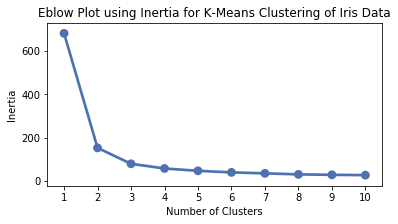

In [12]:
# Graph the Elbow plot

fig_dims = (6, 3)
fig, ax = plt.subplots(figsize=fig_dims)

sns.set_theme(style = "whitegrid")
sns.pointplot(data = elbow_df, x = 'Number of Clusters' ,y = 'Inertia', markers=["o"])\
.set(title='Eblow Plot using Inertia for K-Means Clustering of Iris Data');

The optimal number of clusters is at the "elbow" of the graph, where the Inertia begins to decline in a linear fashion.  In this case the optimal number is 3.

In [13]:
# Display cluster centers for k = 3 clusters in k-means model
cluster_centers[2:3]

[array([[5.006     , 3.428     , 1.462     , 0.246     ],
        [5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
        [6.85      , 3.07368421, 5.74210526, 2.07105263]])]

## Reduce data frame using Principal Components Analysis

In [14]:
# PCA is affected by scale, so we need to scale our features before applying PCA
# StandardScaler will standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) 

x = iris_features.values
scaled_array = StandardScaler().fit_transform(x) #This is an array of the scaled values of the four feature columns
iris_features_scaled = pd.DataFrame(data= np.c_[scaled_array], \
                             columns = ('sepal length', 'sepal width', 'petal length', 'petal width'))

# View scaled data frame
iris_features_scaled.head()

,sepal length,sepal width,petal length,petal width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [15]:
# The first decision in PCA is to select the number of components to reduce to.
# The goal is to reduce dimensions while still retaining most of the variance of the features.

# Start with components=4 (use all) to assess what % of the variance each principal component contains
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(scaled_array)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.72962445 0.22850762 0.03668922 0.00517871]
[0.72962445 0.95813207 0.99482129 1.        ]


Note: based on the cumulative % of variance explained by the principal components, I can see that principal components 1 and 2 contain 95.8% of the variation (information).  Given that two dimensions are easier to visualize and interpret than 3 and that 96% of the variation is good, I'll use 2 principal components for the PCA data frame for the rest of the analysis.

In [16]:
# Apply PCA to the scaled version of the Iris features, using 2 principal components (based on above analysis)
# Create and display PCA Features data frame. 
# Note: there isn't particular meaning assigned to each principal component, the new components are just the two main 
# dimensions of variation.

iris_model = PCA(n_components=2)
principalComponents = iris_model.fit_transform(scaled_array)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
iris_PCA_df = pd.concat([principalDf, iris_df[['target']]], axis = 1)
iris_PCA_df.head()

,principal component 1,principal component 2,target
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa


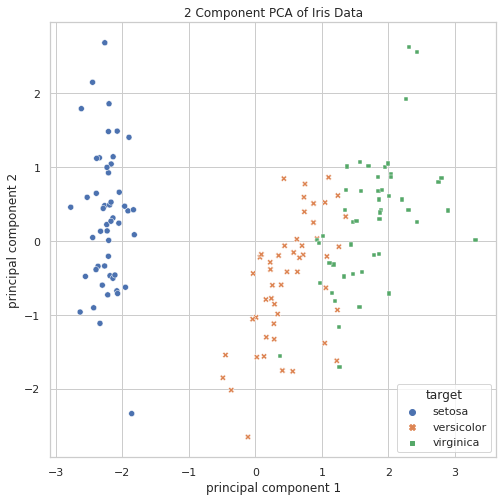

In [17]:
# Scatterplot of the iris data reduced to 2 Principal Components

fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=iris_PCA_df, x='principal component 1',y='principal component 2',hue='target',
                style='target').set(title='2 Component PCA of Iris Data');

## Employ Clustering Techniques - on original data frame and on PCA data frame
* Partitioning Method: K-Means
* Hierarchical Method: sklearn's AgglomerativeClustering
* Density-based Method: DBSCAN

### Partitioning Method: K-Means

#### K-Means on original Iris data set

In [18]:
# Run KMeans on the original features of the Iris data frame, using 3 clusters

k_mean_model = KMeans(n_clusters = 3)
k_mean_model.fit(iris_features)

# Add columns to iris_features dataframe: predicted cluster from KMeans and target label from iris_df
iris_features['k_means']=k_mean_model.predict(iris_features)
iris_features['target']=iris_df['target']

In [19]:
# Display modified iris_features data frame
iris_features.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),k_means,target
0,5.1,3.5,1.4,0.2,1,setosa
1,4.9,3.0,1.4,0.2,1,setosa
2,4.7,3.2,1.3,0.2,1,setosa
3,4.6,3.1,1.5,0.2,1,setosa
4,5.0,3.6,1.4,0.2,1,setosa


In [20]:
# Create table to assess clustering accuracy

my_crosstab = pd.crosstab(index=iris_features["k_means"],columns=iris_features["target"], margins=True) 
my_crosstab

target,setosa,versicolor,virginica,All
k_means,,,,
0,0,48,14,62
1,50,0,0,50
2,0,2,36,38
All,50,50,50,150


The above table indicates an accuracy score of 89.3% ((36+50+48)/150 = .89333)

In [21]:
# Clustering performance evaluation - additional measures

# Rand Index - Adjusted: a function that measures the similarity of the two assignments, adjusted corrects for chance
print('Adjusted Rand Index: ', metrics.adjusted_rand_score(iris_features["target"], iris_features["k_means"]),\
     ", measure the similarity of the two assignments: true label and predicted cluster")
#homogeneity_score: each cluster contains only members of a single class.
print('Homogeneity_score: ',metrics.homogeneity_score(iris_features["target"], iris_features["k_means"]),\
     ", measures that each cluster contains only members of a single class")
#completeness_score: all members of a given class are assigned to the same cluster.
print('Completeness_score: ', metrics.completeness_score(iris_features["target"], iris_features["k_means"]),\
     ", measures that all members of a given class are assigned to the same cluster")
#v_measure_score: harmonic mean of homogeneity and completeness).
print('V-measure: ', metrics.v_measure_score(iris_features["target"], iris_features["k_means"], beta=1.0),\
     ", harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity")

Adjusted Rand Index:  0.7302382722834697 , measure the similarity of the two assignments: true label and predicted cluster
Homogeneity_score:  0.7514854021988339 , measures that each cluster contains only members of a single class
Completeness_score:  0.7649861514489816 , measures that all members of a given class are assigned to the same cluster
V-measure:  0.7581756800057786 , harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity


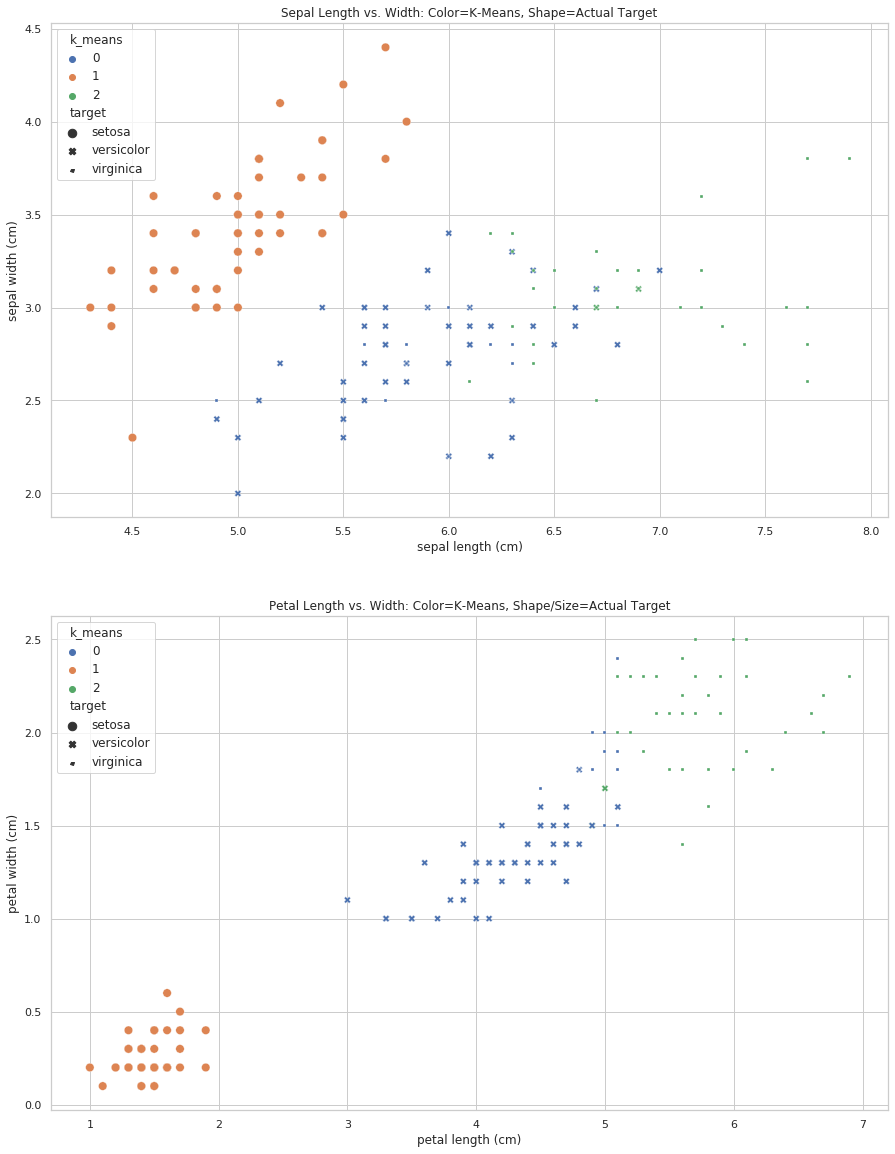

In [22]:
# Graph actual labels vs. clustering for sepal length/sepal width and petal length/petal width

fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (15, 20))
sns.scatterplot(x='sepal length (cm)', y='sepal width (cm)', data = iris_features, hue='k_means',style='target',size='target', palette="deep",ax=ax1)\
.set(title='Sepal Length vs. Width: Color=K-Means, Shape=Actual Target')
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', data = iris_features, hue='k_means',style='target',size='target',palette="deep",ax=ax2)\
.set(title='Petal Length vs. Width: Color=K-Means, Shape/Size=Actual Target');

#### K=Means on PCA Features data frame

In [23]:
# Recall the structure of the PCA Features data frame

iris_PCA_df.head()

,principal component 1,principal component 2,target
0,-2.264703,0.480027,setosa
1,-2.080961,-0.674134,setosa
2,-2.364229,-0.341908,setosa
3,-2.299384,-0.597395,setosa
4,-2.389842,0.646835,setosa


In [24]:
# Run KMeans on the PCA Features data frame, using 3 clusters

k_mean_model = KMeans(n_clusters = 3)
k_mean_model.fit(iris_PCA_df[iris_PCA_df.columns[:-1]])

# Add column to iris_PCA_df dataframe: predicted cluster from KMeans
iris_PCA_df['k_means']=k_mean_model.predict(iris_PCA_df[iris_PCA_df.columns[:-1]])

In [25]:
# Display modified iris_PCA_df data frame
iris_PCA_df.head()

,principal component 1,principal component 2,target,k_means
0,-2.264703,0.480027,setosa,0
1,-2.080961,-0.674134,setosa,0
2,-2.364229,-0.341908,setosa,0
3,-2.299384,-0.597395,setosa,0
4,-2.389842,0.646835,setosa,0


In [26]:
# Create table to assess clustering accuracy

my_crosstab = pd.crosstab(index=iris_PCA_df["k_means"],columns=iris_PCA_df["target"], margins=True) 
my_crosstab

target,setosa,versicolor,virginica,All
k_means,,,,
0,50,0,0,50
1,0,11,36,47
2,0,39,14,53
All,50,50,50,150


The above table indicates an accuracy score of 82.0% ((34+50+39)/150 = .82)

In [27]:
# Clustering performance evaluation - additional measures

# Rand Index - Adjusted: a function that measures the similarity of the two assignments, adjusted corrects for chance
print('Adjusted Rand Index: ', metrics.adjusted_rand_score(iris_PCA_df["target"], iris_PCA_df["k_means"]),\
     ", measure the similarity of the two assignments: true label and predicted cluster")
#homogeneity_score: each cluster contains only members of a single class.
print('Homogeneity_score: ',metrics.homogeneity_score(iris_PCA_df["target"], iris_PCA_df["k_means"]),\
     ", measures that each cluster contains only members of a single class")
#completeness_score: all members of a given class are assigned to the same cluster.
print('Completeness_score: ', metrics.completeness_score(iris_PCA_df["target"], iris_PCA_df["k_means"]),\
     ", measures that all members of a given class are assigned to the same cluster")
#v_measure_score: harmonic mean of homogeneity and completeness).
print('V-measure: ', metrics.v_measure_score(iris_PCA_df["target"], iris_PCA_df["k_means"], beta=1.0),\
     ", harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity")

Adjusted Rand Index:  0.6201351808870379 , measure the similarity of the two assignments: true label and predicted cluster
Homogeneity_score:  0.6591265018049008 , measures that each cluster contains only members of a single class
Completeness_score:  0.6598476779627759 , measures that all members of a given class are assigned to the same cluster
V-measure:  0.659486892724918 , harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity


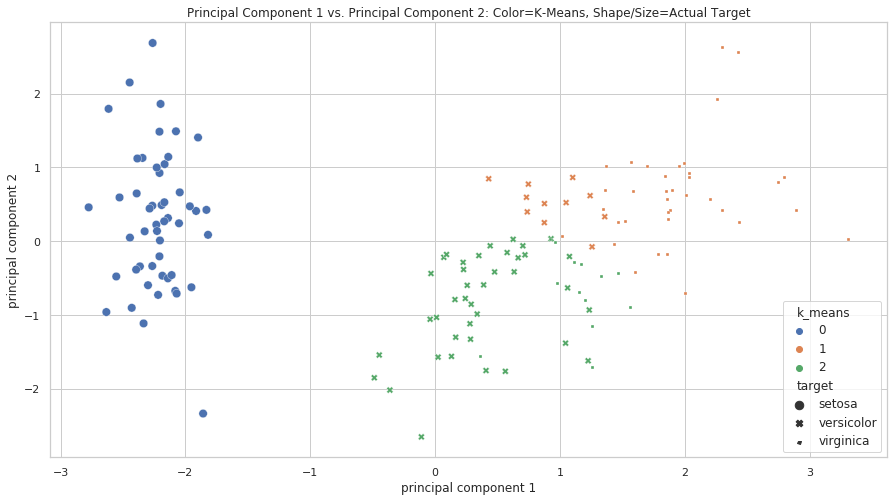

In [28]:
# Graph actual labels vs. clustering for sepal length/sepal width and petal length/petal width

fig, ((ax1)) = plt.subplots(1, figsize = (15, 8))
sns.scatterplot(x='principal component 1', y='principal component 2', data = iris_PCA_df, hue='k_means',style='target',size='target', palette="deep", ax=ax1)\
.set(title='Principal Component 1 vs. Principal Component 2: Color=K-Means, Shape/Size=Actual Target');

## Hierarchical Method: sklearn's AgglomerativeClustering

In [29]:
iris_features.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),k_means,target
0,5.1,3.5,1.4,0.2,1,setosa
1,4.9,3.0,1.4,0.2,1,setosa
2,4.7,3.2,1.3,0.2,1,setosa
3,4.6,3.1,1.5,0.2,1,setosa
4,5.0,3.6,1.4,0.2,1,setosa


In [30]:
iris_features[iris_features.columns[:-2]].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [31]:
data_scaled = normalize(iris_features[iris_features.columns[:-2]])
data_scaled = pd.DataFrame(data_scaled, columns=iris_features.columns[:-2])
data_scaled.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.803773,0.551609,0.220644,0.031521
1,0.828133,0.507020,0.236609,0.033801
2,0.805333,0.548312,0.222752,0.034269
3,0.800030,0.539151,0.260879,0.034784
4,0.790965,0.569495,0.221470,0.031639


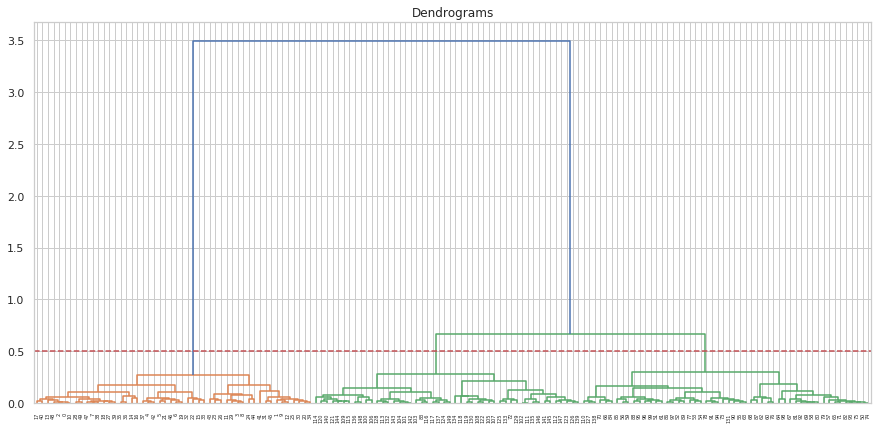

In [32]:
# Like an elbow plot for k-means, a dendogram helps determine the ideal number of clusters for hierarchical clustering
# Note: although this chart shows 2 clusters at the second level, we'll down to the 3rd level and use 3 clusters

plt.figure(figsize=(15, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=0.5, color='r', linestyle='--');

In [33]:
# Note: the linkage criterion determines which distance to use between sets of observation.
# ‘ward’ minimizes the variance of the clusters being merged, euclidean is the distance used for this criterion

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [34]:
data_scaled['hierarchical'] = cluster.fit_predict(data_scaled)
data_scaled['target'] = iris_features['target']
data_scaled.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),hierarchical,target
0,0.803773,0.551609,0.220644,0.031521,1,setosa
1,0.828133,0.507020,0.236609,0.033801,1,setosa
2,0.805333,0.548312,0.222752,0.034269,1,setosa
3,0.800030,0.539151,0.260879,0.034784,1,setosa
4,0.790965,0.569495,0.221470,0.031639,1,setosa


In [35]:
# Create table to assess clustering accuracy

my_crosstab = pd.crosstab(index=data_scaled['hierarchical'],columns=data_scaled["target"], margins=True) 
my_crosstab

target,setosa,versicolor,virginica,All
hierarchical,,,,
0,0,48,4,52
1,50,0,0,50
2,0,2,46,48
All,50,50,50,150


The above table indicates an accuracy score of 96.0% ((48+50+46)/150 = 0.96)

In [36]:
# Clustering performance evaluation - additional measures

# Rand Index - Adjusted: a function that measures the similarity of the two assignments, adjusted corrects for chance
print('Adjusted Rand Index: ', metrics.adjusted_rand_score(data_scaled["target"], data_scaled['hierarchical']),\
     ", measure the similarity of the two assignments: true label and predicted cluster")
#homogeneity_score: each cluster contains only members of a single class.
print('Homogeneity_score: ',metrics.homogeneity_score(data_scaled["target"], data_scaled['hierarchical']),\
     ", measures that each cluster contains only members of a single class")
#completeness_score: all members of a given class are assigned to the same cluster.
print('Completeness_score: ', metrics.completeness_score(data_scaled["target"], data_scaled['hierarchical']),\
     ", measures that all members of a given class are assigned to the same cluster")
#v_measure_score: harmonic mean of homogeneity and completeness).
print('V-measure: ', metrics.v_measure_score(data_scaled["target"], data_scaled['hierarchical'], beta=1.0),\
     ", harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity")

Adjusted Rand Index:  0.8856970310281228 , measure the similarity of the two assignments: true label and predicted cluster
Homogeneity_score:  0.8639756867013153 , measures that each cluster contains only members of a single class
Completeness_score:  0.8643954288752763 , measures that all members of a given class are assigned to the same cluster
V-measure:  0.8641855068202222 , harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity


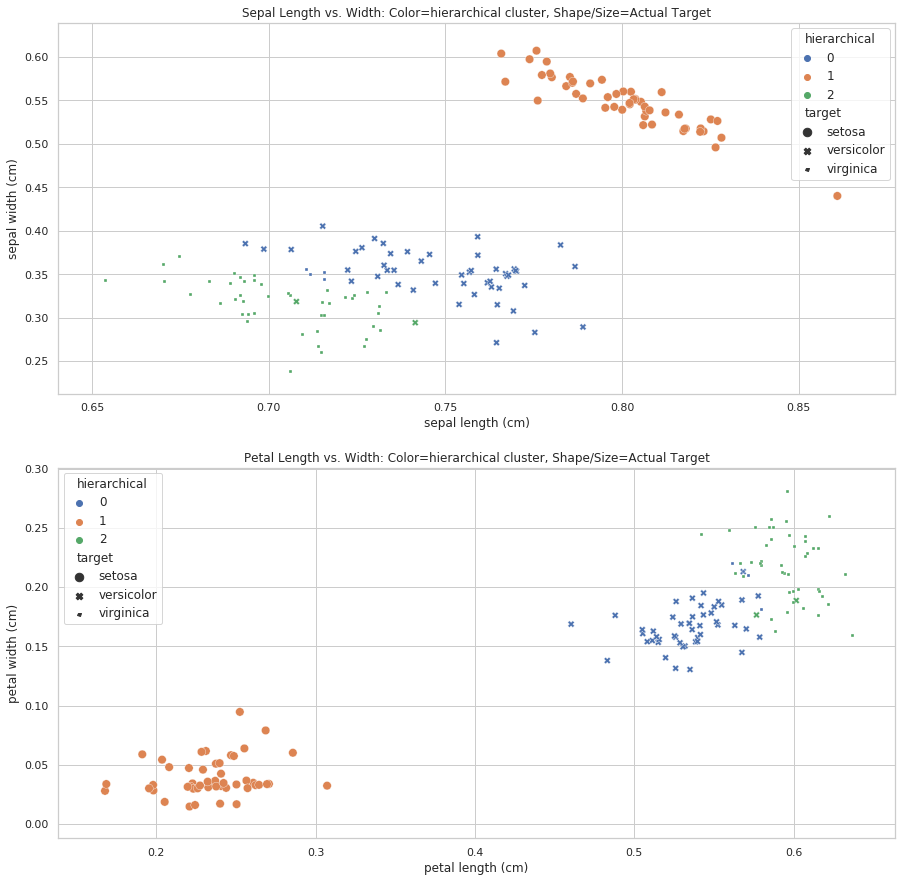

In [37]:
# Graph actual labels vs. clustering for sepal length/sepal width and petal length/petal width

fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (15, 15))
sns.scatterplot(x='sepal length (cm)', y='sepal width (cm)', data = data_scaled, hue='hierarchical',style='target',size='target', palette="deep",ax=ax1)\
.set(title='Sepal Length vs. Width: Color=hierarchical cluster, Shape/Size=Actual Target')
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', data = data_scaled, hue='hierarchical',style='target',size='target',palette="deep",ax=ax2)\
.set(title='Petal Length vs. Width: Color=hierarchical cluster, Shape/Size=Actual Target');

### Density-based Method: DBSCAN

The scikit-learn implementation provides a default for the eps and min_samples parameters, but you’re generally expected to tune those. The eps parameter is the maximum distance between two data points to be considered in the same neighborhood. The min_samples parameter is the minimum amount of data points in a neighborhood to be considered a cluster.

In [51]:
x = iris_features[iris_features.columns[:-2]]
x

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


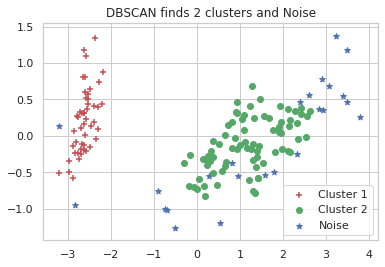

In [47]:
# Check through this example - need to standardize? normalize? Look up diff between the two and when they should be used.
# Do for original df and for pca separately
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
# noise: points that don't have the min # of points within the eps distance (not core points)
dbscan=DBSCAN(eps = 0.45, min_samples = 5)
dbscan.fit(x)
pca=PCA(n_components=2).fit(x)
pca_2d=pca.transform(x)

for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
        
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Noise'])
plt.title('DBSCAN finds 2 clusters and Noise')
plt.show()

In [48]:
# Check through this example - need to standardize? normalize? Look up diff between the two and when they should be used.
# Do for original df and for pca separately
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
# noise: points that don't have the min # of points within the eps distance (not core points)
dbscan=DBSCAN(eps = 0.45, min_samples = 5)
dbscan.fit(x)

DBSCAN(eps=0.45)

In [52]:
# Add columns to iris_features dataframe: predicted cluster from KMeans and target label from iris_df
x['DBSCAN_cluster']=dbscan.labels_
x['target']=iris_df['target']
x

<ipython-input-52-9e9d47e3602f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['DBSCAN_cluster']=dbscan.labels_


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),DBSCAN_cluster,target
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1,virginica
146,6.3,2.5,5.0,1.9,1,virginica
147,6.5,3.0,5.2,2.0,1,virginica
148,6.2,3.4,5.4,2.3,1,virginica


In [54]:
# Create table to assess clustering accuracy

my_crosstab = pd.crosstab(index=x['DBSCAN_cluster'],columns=x['target'], margins=True) 
my_crosstab

target,setosa,versicolor,virginica,All
DBSCAN_cluster,,,,
-1,2,7,15,24
0,48,0,0,48
1,0,43,35,78
All,50,50,50,150


The above table indicates an accuracy score of 84.0% ((48+43+35)/150 = 0.84)- NOT SURE THIS CALC APPLIES HERE B/C it only produced two clusters.

In [55]:
# Clustering performance evaluation - additional measures

# Rand Index - Adjusted: a function that measures the similarity of the two assignments, adjusted corrects for chance
print('Adjusted Rand Index: ', metrics.adjusted_rand_score(x["target"], x['DBSCAN_cluster']),\
     ", measure the similarity of the two assignments: true label and predicted cluster")
#homogeneity_score: each cluster contains only members of a single class.
print('Homogeneity_score: ',metrics.homogeneity_score(x["target"], x['DBSCAN_cluster']),\
     ", measures that each cluster contains only members of a single class")
#completeness_score: all members of a given class are assigned to the same cluster.
print('Completeness_score: ', metrics.completeness_score(x["target"], x['DBSCAN_cluster']),\
     ", measures that all members of a given class are assigned to the same cluster")
#v_measure_score: harmonic mean of homogeneity and completeness).
print('V-measure: ', metrics.v_measure_score(x["target"], x['DBSCAN_cluster'], beta=1.0),\
     ", harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity")

Adjusted Rand Index:  0.5030323746782471 , measure the similarity of the two assignments: true label and predicted cluster
Homogeneity_score:  0.5491319632441521 , measures that each cluster contains only members of a single class
Completeness_score:  0.6045685760507682 , measures that all members of a given class are assigned to the same cluster
V-measure:  0.5755183737460553 , harmonic mean of homogeneity and completeness, beta>1 gives more weight to homogeneity


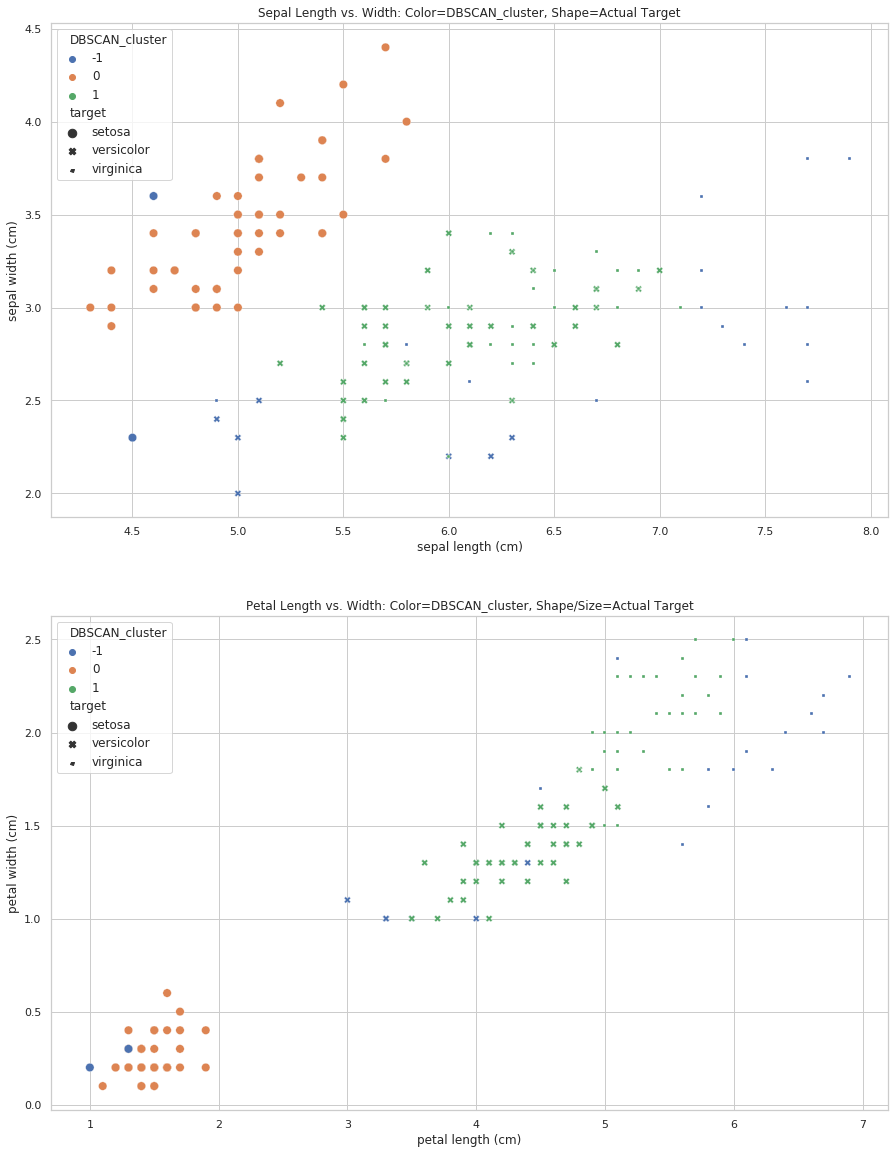

In [56]:
# Graph actual labels vs. clustering for sepal length/sepal width and petal length/petal width

fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (15, 20))
sns.scatterplot(x='sepal length (cm)', y='sepal width (cm)', data = x, hue='DBSCAN_cluster',style='target',size='target', palette="deep",ax=ax1)\
.set(title='Sepal Length vs. Width: Color=DBSCAN_cluster, Shape=Actual Target')
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', data = x, hue='DBSCAN_cluster',style='target',size='target',palette="deep",ax=ax2)\
.set(title='Petal Length vs. Width: Color=DBSCAN_cluster, Shape/Size=Actual Target');

## Conclusions: 